<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20230124.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* Customer Analysis
* Iterators

In [1]:
import pandas as pd
import numpy as np
import plotnine as gg
from plotnine import ggplot, aes
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, time, timezone, timedelta
import os
import re

from functools import reduce
from collections import defaultdict
from scipy import stats

# Customer Analysis

In [2]:
os.listdir()

['.config',
 'KPMG_VI_New_raw_data_update_final.csv',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 '1_orders_dataset.csv',
 'sales_vs_discount.csv',
 'sample-sales-data.csv',
 'WA_Fn-UseC_-Telco-Customer-Churn.csv',
 '1_order_payments_dataset.csv',
 'online_retail_II.xlsx',
 'lead_conversion.csv',
 'cookie_cats.csv',
 'mall_customers.csv',
 'groceries.csv',
 'mock_sales_data.csv',
 'scanner_data.csv',
 'test.csv',
 'sales_data_with_stores.csv',
 'ecommerce-data.csv',
 'match_result_test.csv',
 'WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv',
 'bz_data_analyis.csv',
 'ab_experiment.csv',
 'online_retail.xlsx',
 'sales.csv',
 '1_customers_dataset.csv',
 'app_wau.csv',
 'sample_data']

In [4]:
df = pd.read_csv('cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [18]:
cnt_ret = pd.melt(df, id_vars = ['userid','version','sum_gamerounds'], var_name = 'retention', value_name='result')
cnt_ret = cnt_ret.groupby(['version','retention','result'])['userid'].count().reset_index().rename(columns = {'userid':'cnt'})
cnt_ret = cnt_ret[cnt_ret['result'] == True]
cnt_ret['flag'] = cnt_ret['retention'] + '_' + cnt_ret['version']
cnt_ret = cnt_ret.sort_values(['flag'])
cnt_ret

,version,retention,result,cnt,flag
1,gate_30,retention_1,True,20034,retention_1_gate_30
5,gate_40,retention_1,True,20119,retention_1_gate_40
3,gate_30,retention_7,True,8502,retention_7_gate_30
7,gate_40,retention_7,True,8279,retention_7_gate_40


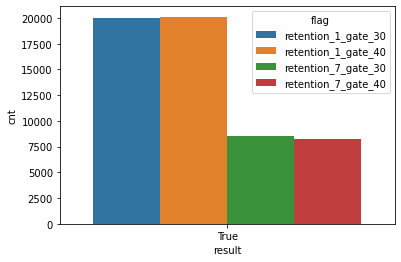

In [19]:
sns.barplot(data = cnt_ret, x = 'result', y = 'cnt', hue = 'flag')

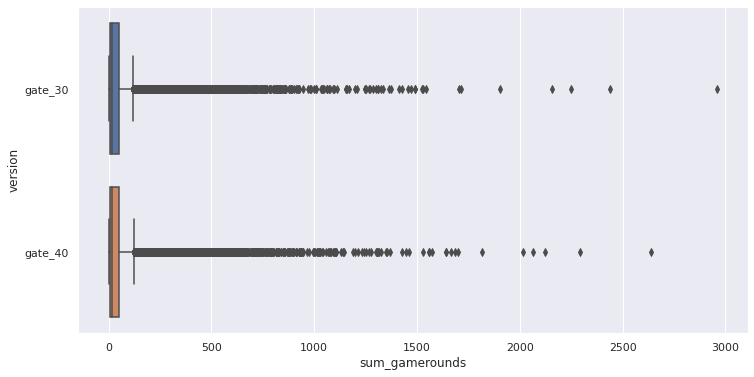

In [27]:
sns.set(rc = {'figure.figsize':[12, 6]})
ax = sns.boxplot(data = df, x = 'sum_gamerounds', y = 'version')
plt.show()

In [22]:
df = df[df['sum_gamerounds'] <= 10000]

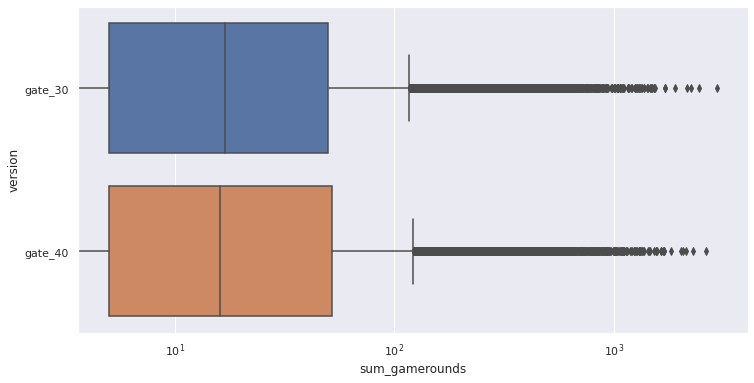

In [26]:
sns.set(rc = {'figure.figsize':[12, 6]})
ax = sns.boxplot(data = df, x = 'sum_gamerounds', y = 'version')
ax.set_xscale('log')
plt.show()

((array([-4.32330209, -4.12353114, -4.01483812, ...,  4.01483812,
          4.12353114,  4.32330209]),
  array([   0,    0,    0, ..., 2438, 2640, 2961])),
 (71.54691083221576, 51.32025324876927, 0.696746813756345))

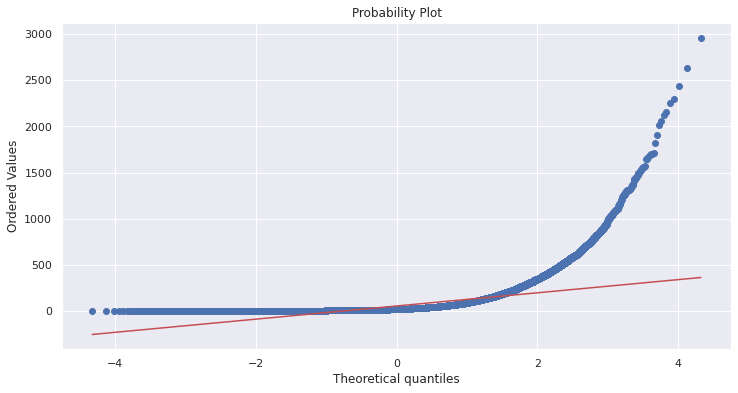

In [32]:
stats.probplot(df['sum_gamerounds'], dist = 'norm', plot = plt)

In [30]:
stat, r = stats.shapiro(df['sum_gamerounds'])
print(str(stat) + '\n' + str(r))

0.48558586835861206
0.0


In [33]:
stat, r = stats.normaltest(df['sum_gamerounds'])
print(str(stat) + '\n' + str(r))

104181.60505148777
0.0


## Anderson-Darling Normality Test
* It gives a range of critical values, 
* at which the null hypothesis can be failed to rejected 
* if the calculated statistic is less than the critical value.


In [44]:
res = stats.anderson(df['sum_gamerounds'])

print('Stat = %.3f\n' %(res.statistic))

for i in range(len(res.critical_values)) :

  sig_lev, crit_val = res.significance_level[i], res.critical_values[i]
  
  if res.statistic < crit_val :
    print(f'Probably Gaussian : {crit_val} critical value at {sig_lev} significance level' )
  else :
    print(f'Probably Not Gaussian : {crit_val} critical value at {sig_lev} significance level' )

Stat = 13369.549

Probably Not Gaussian : 0.576 critical value at 15.0 significance level
Probably Not Gaussian : 0.656 critical value at 10.0 significance level
Probably Not Gaussian : 0.787 critical value at 5.0 significance level
Probably Not Gaussian : 0.918 critical value at 2.5 significance level
Probably Not Gaussian : 1.092 critical value at 1.0 significance level


In [46]:
stat, r = stats.chisquare(df['sum_gamerounds'])
print(str(stat) + '\n' + str(r))

18528909.99029161
0.0


## Bootstrapping

In [57]:
n = 1000
boots = pd.DataFrame([df.sample(frac = .1, replace = True).groupby(['version'])['sum_gamerounds'].mean() for i in range(n)])
boots

version,gate_30,gate_40
sum_gamerounds,51.285873,52.438314
sum_gamerounds,50.435373,48.644562
sum_gamerounds,50.271814,50.919348
sum_gamerounds,52.853277,51.310026
sum_gamerounds,50.858250,50.257549
...,...,...
sum_gamerounds,51.488444,50.325293
sum_gamerounds,50.336799,52.018716
sum_gamerounds,51.485278,52.029319
sum_gamerounds,52.043362,51.444494


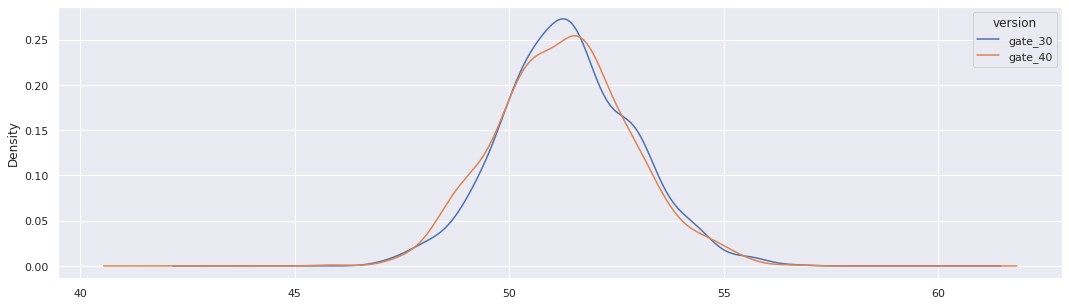

In [58]:
boots.plot.kde()
sns.set(rc = {'figure.figsize':(18,5)})
plt.show()

* If the p-value is larger than the chosen significance level then we can state that we can’t reject the null. 
* Hence, there is not enough evidence to state that 
* there is a statistically significant difference in Control and Experimental sample means.

In [61]:
boots_diff = boots['gate_40'] - boots['gate_30']
boots_diff = boots_diff[boots_diff > 0]
len(boots_diff)/n


0.481

# Iterators

In [62]:
users = [{'mail': 'gregorythomas@gmail.com', 'name': 'Brett Holland', 'sex': 'M', 'age': 73},
 {'mail': 'hintoncynthia@hotmail.com', 'name': 'Madison Martinez', 'sex': 'F', 'age': 29},
 {'mail': 'wwagner@gmail.com', 'name': 'Michael Jenkins', 'sex': 'M', 'age': 51},
 {'mail': 'daniel79@gmail.com', 'name': 'Karen Rodriguez', 'sex': 'F', 'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]
users

[{'mail': 'gregorythomas@gmail.com',
  'name': 'Brett Holland',
  'sex': 'M',
  'age': 73},
 {'mail': 'hintoncynthia@hotmail.com',
  'name': 'Madison Martinez',
  'sex': 'F',
  'age': 29},
 {'mail': 'wwagner@gmail.com',
  'name': 'Michael Jenkins',
  'sex': 'M',
  'age': 51},
 {'mail': 'daniel79@gmail.com',
  'name': 'Karen Rodriguez',
  'sex': 'F',
  'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]

In [63]:
{k : eval(f'reduce(lambda acc, cur : acc + [cur["{k}"]], users, [])') for k in list(users[0].keys())}

{'mail': ['gregorythomas@gmail.com',
  'hintoncynthia@hotmail.com',
  'wwagner@gmail.com',
  'daniel79@gmail.com',
  'ujackson@gmail.com'],
 'name': ['Brett Holland',
  'Madison Martinez',
  'Michael Jenkins',
  'Karen Rodriguez',
  'Amber Rhodes'],
 'sex': ['M', 'F', 'M', 'F', 'F'],
 'age': [73, 29, 51, 32, 42]}